In [1]:
import re
import torch as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from functools import reduce
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

## Monomer

In [2]:
# parameters
filepaths = {
    "wt": glob("benchmark_data/wt/monomers/*.pdb"),
    "baseline": glob("benchmark_data/wt/monomers/alphafold_models_ss/*_rank_001_*.pdb"),
    "carbonara_maxseqid": glob("benchmark_data/carbonara/monomers/maxseqid/alphafold_models_ss/*_rank_001_*.pdb"),
    "mpnn": glob("benchmark_data/mpnn/monomers/alphafold_models_ss/*_rank_001_*.pdb"),
    "esm": glob("benchmark_data/esm/monomers/alphafold_models_ss/*_rank_001_*.pdb"),
}
keys = ["baseline", "carbonara_maxseqid", "mpnn", "esm"]

# read structures 
structs = {}
for key in filepaths:
    structs[key] = {}
    for fp in filepaths[key]:
        sid = re.search(r'/([0-9A-Z]{4}(_[A-Z])?)', fp)[1]
        structs[key][sid] = sp.read_pdb(fp)

# evaluate structures 
results = []
for key in keys:
    for sid in structs[key]:
        if sid in structs["wt"]:
            # get structures pair
            struct_ref = structs["wt"][sid]
            struct = structs[key][sid]

            # get C_alpha coordinates
            xyz_ca_ref = pt.from_numpy(sp.atom_select(struct_ref, struct_ref['name'] == 'CA')['xyz'])
            xyz_ca = pt.from_numpy(sp.atom_select(struct, struct['name'] == 'CA')['xyz'])

            # size check
            struct_ca_ref = sp.atom_select(struct_ref, struct_ref['name'] == 'CA')
            struct_ca = sp.atom_select(struct, struct['name'] == 'CA')

            subs_ca = sp.split_by_chain(struct_ca)
            subs_ca_ref = sp.split_by_chain(struct_ca_ref)

            b_size = np.all([subs_ca[cid]['xyz'].shape[0] == subs_ca_ref[cid_ref]['xyz'].shape[0] for cid,cid_ref in zip(subs_ca, subs_ca_ref)])
        
            #if xyz_ca_ref.shape[0] == xyz_ca.shape[0]:
            if b_size:
                rmsd = sp.compute_rmsd(xyz_ca_ref, xyz_ca).item()
                lddt = pt.mean(rt.compute_lDDT(xyz_ca_ref, xyz_ca)).item()
                plddt = np.mean(sp.atom_select(struct, struct['name'] == 'CA')['bfactor'])

                results.append({
                    "method": key,
                    'sid': sid,
                    'rmsd': rmsd,
                    'lddt': lddt,
                    'plddt': plddt,
                    'size': xyz_ca.shape[0],
                })
            else:
                print(sid, xyz_ca_ref.shape[0], xyz_ca.shape[0])

# pack results
dfm = pd.DataFrame(results).sort_values(["sid", "method"])
dfm = dfm.groupby("sid").filter(lambda x: len(x)==len(keys))

# merge with tmscore
dfmtm = pd.read_csv("results/monomers_structure_ss_tmscore.csv")
dfm = pd.merge(dfm, dfmtm, on=['method', 'sid'])

# merge with sequence information
dfms = pd.read_csv("results/monomers_sequence_analysis.csv")
dfm = pd.merge(dfm, dfms, on=['method', 'sid'])

# save and display
dfm.to_csv("results/monomers_structure_analysis.csv", index=False)
dfm

,method,sid,rmsd,lddt,plddt,size,tmscore,sequence_identity,sequence_similarity,len
0,baseline,1ABO_A,11.020249,45.409569,51.445690,58,0.2348,1.000000,1.000000,58
1,carbonara_maxseqid,1ABO_A,1.075846,93.378464,87.691379,58,0.9334,0.637931,0.827586,58
2,esm,1ABO_A,2.106327,82.434975,89.285345,58,0.8388,0.551724,0.741379,58
3,mpnn,1ABO_A,2.502056,71.773361,71.814138,58,0.6740,0.500000,0.689655,58
4,baseline,1ABQ_A,10.949207,47.962135,50.279821,56,0.2338,1.000000,1.000000,56
...,...,...,...,...,...,...,...,...,...,...
455,mpnn,6PNW_B,11.019302,60.988289,55.067903,62,0.0000,0.467742,0.661290,62
456,baseline,6R3C_A,6.131505,55.641418,42.035283,159,0.6114,1.000000,1.000000,159
457,carbonara_maxseqid,6R3C_A,4.035446,60.539001,58.477044,159,0.7052,0.283019,0.484277,159
458,esm,6R3C_A,11.484378,51.078819,51.806981,159,0.5381,0.314465,0.477987,159


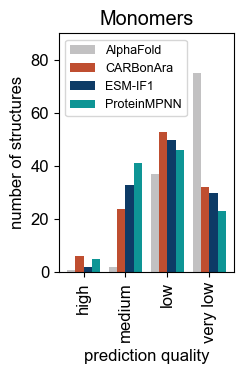

,baseline,carbonara_maxseqid,esm,mpnn
0,1,6,2,5
1,2,24,33,41
2,37,53,50,46
3,75,32,30,23


In [3]:
# classify structure predictions by quality
nqm_af = {}
#for key in ['lddt_base', 'lddt_carbonara', 'lddt_mpnn', 'lddt_esm']:
for key in ['baseline', 'carbonara_maxseqid', 'esm', 'mpnn']:
    v = dfm[dfm['method'] == key]["lddt"].values
    nqm_af[key] = [
        np.sum(v >= 90),
        np.sum((v >= 70) & (v < 90)),
        np.sum((v >= 50) & (v < 70)),
        np.sum((v < 50)),
    ]

df_nqm = pd.DataFrame(nqm_af)

# plot data
y = df_nqm.values
x = np.arange(y.shape[0])
labels = ["high", "medium", "low", "very low"]

# plot
plt.figure(figsize=(2.6,3.9))
plt.bar(x-0.3, y[:,0], width=0.2, color=colors[3], label="AlphaFold")
plt.bar(x-0.1, y[:,1], width=0.2, color=colors[0], label="CARBonAra")
plt.bar(x+0.1, y[:,2], width=0.2, color=colors[1], label="ESM-IF1")
plt.bar(x+0.3, y[:,3], width=0.2, color=colors[2], label="ProteinMPNN")
plt.ylim(0, 90)
plt.legend(loc='upper left', prop={'size': 9})
plt.title("Monomers")
plt.xlabel('prediction quality')
plt.ylabel('number of structures')
plt.xticks(x, labels, rotation=90)
plt.tight_layout()
#plt.savefig("graphs/alphafold_validation_monomers.svg")
plt.show()

# debug
df_nqm

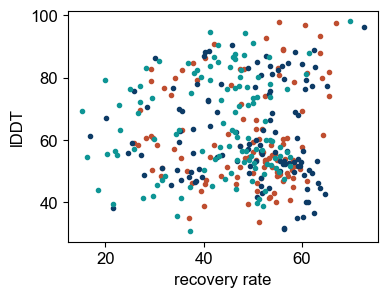

In [4]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y0 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = np.stack([dfm[dfm['method'] == key]['lddt'].values for key in keys], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y1[:,i], '.', color=colors[i])
plt.xlabel('recovery rate')
plt.ylabel('lDDT')
#plt.ylim(90, 100)
plt.show()

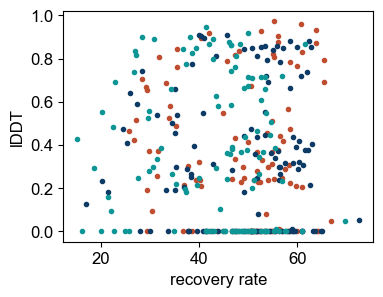

In [5]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y0 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = np.stack([dfm[dfm['method'] == key]['tmscore'].values for key in keys], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y1[:,i], '.', color=colors[i])
plt.xlabel('recovery rate')
plt.ylabel('lDDT')
#plt.ylim(90, 100)
plt.show()

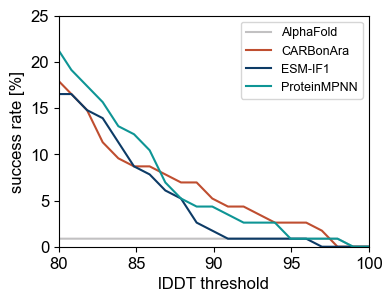

In [6]:
# parameters
keys = ["baseline", "carbonara_maxseqid", "esm", "mpnn"]
labels = ['AlphaFold', 'CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y = np.stack([dfm[dfm['method'] == key]['lddt'].values for key in keys], axis=1)

# get data
x = np.linspace(0.0, 100.0, 100)
v0 = 1e2 * np.stack([np.mean((y[:,i].reshape(-1,1) > x.reshape(1,-1)).astype(float), axis=0) for i in range(y.shape[1])], axis=1)

# plot
plt.figure(figsize=(4,3))
plt.plot(x, v0[:,0], color=colors[3], label=labels[0])
plt.plot(x, v0[:,1], color=colors[0], label=labels[1])
plt.plot(x, v0[:,2], color=colors[1], label=labels[2])
plt.plot(x, v0[:,3], color=colors[2], label=labels[3])
plt.xlim(80, 100)
plt.ylim(0, 25)
plt.legend(loc='best', prop={'size': 9})
plt.xlabel('lDDT threshold')
plt.ylabel('success rate [%]')
plt.show()

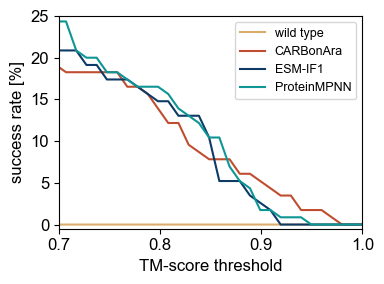

In [14]:
# parameters
keys = ["baseline", "carbonara_maxseqid", "esm", "mpnn"]
labels = ['wild type', 'CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y = np.stack([dfm[dfm['method'] == key]['tmscore'].values for key in keys], axis=1)

# get data
x = np.linspace(0.0, 1.0, 100)
v0 = 1e2 * np.stack([np.mean((y[:,i].reshape(-1,1) > x.reshape(1,-1)).astype(float), axis=0) for i in range(y.shape[1])], axis=1)

# plot
plt.figure(figsize=(4,3))
plt.plot(x, v0[:,0], color=colors[4], label=labels[0])
plt.plot(x, v0[:,1], color=colors[0], label=labels[1])
plt.plot(x, v0[:,2], color=colors[1], label=labels[2])
plt.plot(x, v0[:,3], color=colors[2], label=labels[3])
plt.xlim(0.7, 1.0)
plt.ylim(-0.5, 25)
plt.legend(loc='best', prop={'size': 9})
plt.xlabel('TM-score threshold')
plt.ylabel('success rate [%]')
plt.tight_layout()
plt.savefig("graphs/methods_comparison_monomers_tmscore.svg")
plt.show()

## Dimer

In [8]:
# parameters
filepaths = {
    "wt": glob("benchmark_data/wt/dimers/*.pdb"),
    "baseline": glob("benchmark_data/wt/dimers/alphafold_models_ss/*_rank_001_*.pdb"),
    "carbonara_maxseqid": glob("benchmark_data/carbonara/dimers/maxseqid/alphafold_models_ss/*_rank_001_*.pdb"),
    "mpnn": glob("benchmark_data/mpnn/dimers/alphafold_models_ss/*_rank_001_*.pdb"),
    "esm": glob("benchmark_data/esm/dimers/alphafold_models_ss/*_rank_001_*.pdb"),
}
keys = ["baseline", "carbonara_maxseqid", "mpnn", "esm"]

# read structures 
structs = {}
for key in filepaths:
    structs[key] = {}
    for fp in filepaths[key]:
        sid = re.search(r'/([0-9A-Z]{4}(_[A-Z])?)', fp)[1]
        structs[key][sid] = sp.read_pdb(fp)

# evaluate structures 
results = []
for key in keys:
    for sid in structs[key]:
        pdbid = sid.split('_')[0]
        if pdbid in structs["wt"]:
            # get structures pair
            struct_ref = structs["wt"][pdbid]
            struct = structs[key][sid]

            # size check
            struct_ca_ref = sp.atom_select(struct_ref, struct_ref['name'] == 'CA')
            struct_ca = sp.atom_select(struct, struct['name'] == 'CA')

            # check size
            subs_ca = sp.split_by_chain(struct_ca)
            #subs_ca_ref = sp.split_by_chain(struct_ca_ref)

            # get C_alpha coordinates
            xyz_ca_ref = pt.from_numpy(struct_ca_ref['xyz'])
            
            # find chain order
            xyz_ca_l = [
                pt.from_numpy(sp.concatenate_chains({cid:subs_ca[cid] for cid in subs_ca})['xyz']),
                pt.from_numpy(sp.concatenate_chains({cid:subs_ca[cid] for cid in reversed(subs_ca)})['xyz']),
            ]
            iord = np.argmin([sp.compute_rmsd(xyz_ca_ref, xyz_ca).item() for xyz_ca in xyz_ca_l])
            
            # compute scores
            rmsd = sp.compute_rmsd(xyz_ca_ref, xyz_ca_l[iord]).item()
            lddt = pt.mean(rt.compute_lDDT(xyz_ca_ref, xyz_ca_l[iord])).item()
            plddt = np.mean(sp.atom_select(struct, struct['name'] == 'CA')['bfactor'])

            # store results
            results.append({
                "method": key,
                'sid': sid,
                'rmsd': rmsd,
                'lddt': lddt,
                'plddt': plddt,
                'size': xyz_ca.shape[0],
            })

# pack results
dfd = pd.DataFrame(results).sort_values(["sid", "method"])
dfd = dfd.groupby("sid").filter(lambda x: len(x)==len(keys))

# merge with tmscore
dfdtm = pd.read_csv("results/dimers_structure_ss_tmscore.csv")
dfd = pd.merge(dfd, dfdtm, on=['method', 'sid'])

# merge with sequence information
dfds = pd.read_csv("results/dimers_sequence_analysis.csv")
dfd = pd.merge(dfd, dfds, on=['method', 'sid'])

# save and display
dfd.to_csv("results/dimers_structure_analysis.csv", index=False)
dfd

,rmsd,lddt,plddt,size,tmscore,method,sid,sequence_identity,sequence_similarity,len


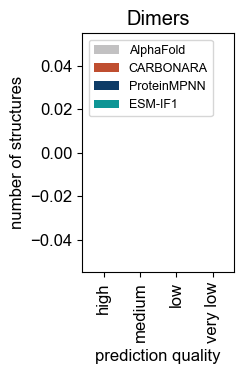

,baseline,carbonara_maxseqid,mpnn,esm
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0


In [9]:
# classify structure predictions by quality
nqm_af2 = {}
#for key in ['lddt_base', 'lddt_carbonara', 'lddt_mpnn', 'lddt_esm']:
for key in ['baseline', 'carbonara_maxseqid', 'mpnn', 'esm']:
    v = dfd[dfd['method'] == key]["lddt"].values
    nqm_af2[key] = [
        np.sum(v >= 90),
        np.sum((v >= 70) & (v < 90)),
        np.sum((v >= 50) & (v < 70)),
        np.sum((v < 50)),
    ]

df2_nqm = pd.DataFrame(nqm_af2)

# plot data
y = df2_nqm.values
x = np.arange(y.shape[0])
labels = ["high", "medium", "low", "very low"]

# plot
plt.figure(figsize=(2.6,3.9))
plt.bar(x-0.3, y[:,0], width=0.2, color=colors[3], label="AlphaFold")
plt.bar(x-0.1, y[:,1], width=0.2, color=colors[0], label="CARBONARA")
plt.bar(x+0.1, y[:,2], width=0.2, color=colors[1], label="ProteinMPNN")
plt.bar(x+0.3, y[:,3], width=0.2, color=colors[2], label="ESM-IF1")
#plt.ylim(0, 17)
plt.legend(loc='upper left', prop={'size': 9})
plt.title("Dimers")
plt.xlabel('prediction quality')
plt.ylabel('number of structures')
plt.xticks(x, labels, rotation=90)
plt.tight_layout()
#plt.savefig("graphs/alphafold_validation_dimers.svg")
plt.show()

# debug
df2_nqm

/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


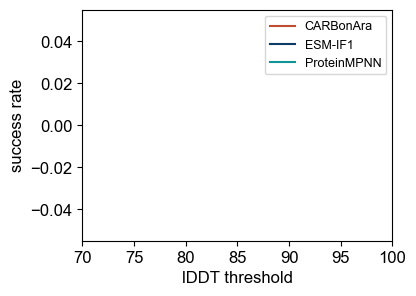

In [10]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y = np.stack([dfd[dfd['method'] == key]['lddt'].values for key in keys], axis=1)

# get data
x = np.linspace(0.0, 100.0, 100)
v0 = np.stack([np.mean((y[:,i].reshape(-1,1) > x.reshape(1,-1)).astype(float), axis=0) for i in range(y.shape[1])], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(v0.shape[1]):
    plt.plot(x, v0[:,i], color=colors[i], label=labels[i])
plt.xlim(70, 100)
#plt.ylim(0.0, 0.3)
plt.legend(loc='best', prop={'size': 9})
plt.xlabel('lDDT threshold')
plt.ylabel('success rate')
plt.show()

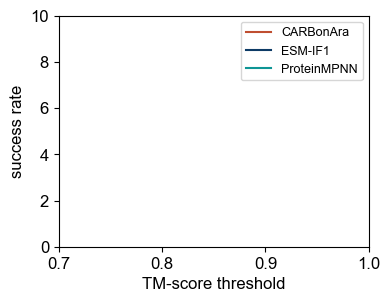

In [11]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN']

# get data
y = np.stack([dfd[dfd['method'] == key]['tmscore'].values for key in keys], axis=1)

# get data
x = np.linspace(0.0, 1.0, 100)
v0 = 1e2*np.stack([np.mean((y[:,i].reshape(-1,1) > x.reshape(1,-1)).astype(float), axis=0) for i in range(y.shape[1])], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(v0.shape[1]):
    plt.plot(x, v0[:,i], color=colors[i], label=labels[i])
plt.xlim(0.7, 1.0)
plt.ylim(0.0, 10.0)
plt.legend(loc='best', prop={'size': 9})
plt.xlabel('TM-score threshold')
plt.ylabel('success rate')
plt.show()